In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import udf, col, lower, regexp_replace
import re
import pandas as pd
import numpy as np
import string


# Data Sourcing
Importing data and only keeping necessary columns

- Insult: Label
- Comment: Text

In [0]:
df = spark.read.csv('/FileStore/tables/cyberbullydata.csv',inferSchema=True,header=True)
spark.conf.set("spark.sql.legacy.timeParserPolicy","Legacy")

df=df.select(['Insult','Comment'])

df.dropna()


Out[12]: DataFrame[Insult: int, Comment: string]

# Numerical Features
Created various number of numerical features to get more familiar with the different statistics for the two given labels. These statistics will be used for visualization and exploration of our texts. Some of the data points extracted were:


1. The length of each comment counted by the number of characters
2. The total number of words per each comment
3. Number of Unique Words per comment
4. The average length of words (in characters) per comment
5. Number of punctuations

In [0]:

import pyspark.sql.functions as f
import string
from pyspark.sql.functions import array_contains
	 
df = df.withColumn("text_length", f.length("Comment"))
df = df.withColumn('word_count', f.size(f.split(f.col('Comment'), ' ')))
df = df.withColumn('uniqWords',f.size(f.array_distinct(f.split(f.col('Comment'), ' ')))) 
df = df.withColumn('mean_word_length',f.col('text_length')/f.col('word_count')) 

import string

#insult,comment, text_length,word_count,uniqWords,mean_word_length
punc_rdd=df.rdd.map(lambda x:(x[0],x[1],x[2],x[3],x[4],x[5],len([c for c in str(x) if c in string.punctuation])))

df = punc_rdd.toDF(["insult","Comment","text_length","word_count","uniqWords","mean_word_length","countpunc"])
df.printSchema()
df.show()

root
 |-- insult: long (nullable = true)
 |-- Comment: string (nullable = true)
 |-- text_length: long (nullable = true)
 |-- word_count: long (nullable = true)
 |-- uniqWords: long (nullable = true)
 |-- mean_word_length: double (nullable = true)
 |-- countpunc: long (nullable = true)

+------+--------------------+-----------+----------+---------+-----------------+---------+
|insult|             Comment|text_length|word_count|uniqWords| mean_word_length|countpunc|
+------+--------------------+-----------+----------+---------+-----------------+---------+
|     0|"""THE DRUDGE REP...|        189|        27|       26|              7.0|       75|
|     0|"""@ian21\xa0""Ro...|         47|         6|        6|7.833333333333333|       28|
|     1|"""Agree with Ala...|         69|        14|       12|4.928571428571429|       24|
|     0|"""Really?\\n\\nI...|         70|        10|       10|              7.0|       32|
|     0|"""Really suck is...|         29|         5|        5|             

# Cleaning & Preprocessing

For cleaning and preprocessing we used a UDF (User-Defined Function) to replace all the twitter mentions/handles with a common name 'refertoperson' this will allow us to capture these mentions across all comments. 

We then used a pipeline to clean this text. Some of the cleaning includes:

- removing links
- removing text formatting symbols and emojicons
- removing html formats
- removing punctuations

We then used preprocessing steps to:
- Tokenize
- Lemmatize
- Remove Stopwords

While we also attempted to use Ngrams and spell-cheking in our text we noticed that these approaches deteriorated the classification power of our models

In [0]:
import re
import string
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

@udf(returnType=StringType())
def replaceHandle(iter:str) -> str:
    """ UDF function to replace twitter handles with a common @refertoperson
    Args:
        - iter(str): string to be replaced
    Returns:
        string replaced
    """
    regexp='@[A-z0-9_]+'
    ret=re.sub(regexp,"@refertoperson",iter)
    return ret
    
df = df.withColumn('Comment', replaceHandle('Comment'))
df.show(5)

        

+------+--------------------+-----------+----------+---------+-----------------+---------+
|insult|             Comment|text_length|word_count|uniqWords| mean_word_length|countpunc|
+------+--------------------+-----------+----------+---------+-----------------+---------+
|     0|"""THE DRUDGE REP...|        189|        27|       26|              7.0|       75|
|     0|"""@refertoperson...|         47|         6|        6|7.833333333333333|       28|
|     1|"""Agree with Ala...|         69|        14|       12|4.928571428571429|       24|
|     0|"""Really?\\n\\nI...|         70|        10|       10|              7.0|       32|
|     0|"""Really suck is...|         29|         5|        5|              5.8|       25|
+------+--------------------+-----------+----------+---------+-----------------+---------+
only showing top 5 rows



In [0]:
from sparknlp.annotator import DocumentNormalizer, Tokenizer, LemmatizerModel, StopWordsCleaner, Normalizer, NGramGenerator
from sparknlp.base import DocumentAssembler, TokenAssembler
from pyspark.ml import Pipeline

# Creates document formats
documentAssembler = (DocumentAssembler()\
                     .setInputCol('Comment')\
                     .setOutputCol('Document')
                    )

# Cleans Documents
doc_norm_patterns = ["<[^>]>","_","https?:\/\/.*[\r\n]*", '"', r"\\n", r"\\u\d+","0_0"]
documentNormalizer = DocumentNormalizer() \
    .setInputCols("Document") \
    .setOutputCol("NormalizedDocument") \
    .setAction("clean") \
    .setPatterns(doc_norm_patterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

# Tokenizes
tokenizer = Tokenizer()\
    .setInputCols(["NormalizedDocument"])\
    .setOutputCol("Token").fit(df)

# Normalizer - cleans tokens remaining
normalizer = Normalizer() \
    .setInputCols(["Token"]) \
    .setOutputCol("Normalized") \
    .setCleanupPatterns([r"\\x.\d",r"\\"]) # "@[^\s]+"

# # Spell Checker
# spellChecker = ContextSpellCheckerModel \
#     .pretrained() \
#     .setTradeoff(12.0) \
#     .setInputCols("Token") \
#     .setOutputCol("Checked")

# Lemmatize
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["Normalized"]) \
    .setOutputCol("Lemma")

# Remove Stop Words
stopWords = StopWordsCleaner() \
     .setInputCols(["Lemma"]) \
     .setOutputCol("CleanTokens") \
     .setCaseSensitive(False)

# Remove Punctuation
punctRemover = Normalizer()\
    .setInputCols(["CleanTokens"])\
    .setOutputCol("PunctFree")\
    .setCleanupPatterns(["[^\w\d\s]"])

# Create NGrams
nGrams = NGramGenerator() \
    .setInputCols(["PunctFree"]) \
    .setOutputCol("ngrams") \
    .setN(4)

# Pipeline
pipeline = Pipeline().setStages([
    documentAssembler,
    documentNormalizer,
    tokenizer,
    normalizer,
    lemmatizer,
    stopWords,
    punctRemover,
    nGrams
])


pipelineModel = pipeline.fit(df)
preprocessed = pipelineModel.transform(df)

# Selecting only clean columns for analysis
df=preprocessed.withColumn("TokensPunct", preprocessed.CleanTokens.result)\
            .withColumn("TokensNoPunct", preprocessed.PunctFree.result)\
            .withColumn("Ngrams4", preprocessed.ngrams.result)\
            .selectExpr("Insult", 
                     "Comment",
                     "Ngrams4",
                     "TokensPunct",
                     "TokensNoPunct",
                     "text_length",
                     "word_count",
                     "uniqWords",
                     "mean_word_length",
                     "countpunc")
display(df.limit(5))


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


Insult,Comment,Ngrams4,TokensPunct,TokensNoPunct,text_length,word_count,uniqWords,mean_word_length,countpunc
0,"""""""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see this story on foxfag forum because they suck bIacks and gay 0bama all the way to the crack.\\n\\n\\n\\n\\n\\n\\n\\nOn Tuesday Rep. Darrell Issa","List(drudge report see story, report see story foxfag, see story foxfag forum, story foxfag forum suck, foxfag forum suck biacks, forum suck biacks gay, suck biacks gay 0bama, biacks gay 0bama way, gay 0bama way crack, 0bama way crack tuesday, way crack tuesday rep, crack tuesday rep darrell, tuesday rep darrell issa)","List(drudge, report, see, story, foxfag, forum, suck, biacks, gay, 0bama, way, crack., tuesday, rep, ., darrell, issa)","List(drudge, report, see, story, foxfag, forum, suck, biacks, gay, 0bama, way, crack, tuesday, rep, darrell, issa)",189,27,26,7.0,75
0,"""""""@refertoperson""""Roger Clemens is the fucking man","List(refertoperson roger clemens fucking, roger clemens fucking man)","List(@refertoperson, roger, clemens, fucking, man)","List(refertoperson, roger, clemens, fucking, man)",47,6,6,7.833333333333333,28
1,"""""""Agree with Alan you are an extremest idiot. You are not American","List(agree alan extreme idiot, alan extreme idiot american)","List(agree, alan, extreme, idiot, ., american)","List(agree, alan, extreme, idiot, american)",69,14,12,4.928571428571429,24
0,"""""""Really?\\n\\nI see Marc Lamont Hill on various programs quite often","List(really see marc lamont, see marc lamont hill, marc lamont hill various, lamont hill various program, hill various program quite, various program quite often)","List(really?, see, marc, lamont, hill, various, program, quite, often)","List(really, see, marc, lamont, hill, various, program, quite, often)",70,10,10,7.0,32
0,"""""""Really suck isn't the word",List(),"List(really, suck, word)","List(really, suck, word)",29,5,5,5.8,25


# Text Transformations: Count Vectors & TFIDF

To be able to model our text data we converted these into numerical inputs. We used two approaches Count Vectors, which count the number of instances of a particular term in our comments. TFIDF which counts frequency but also takes into consideration the occurances across the text corpus by using a weighted count of the terms occurance accross the corpus. 

We applied these two methods to our text with and without punctuations

In [0]:
#https://spark.apache.org/docs/3.2.0/ml-features.html#tf-idf\
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import CountVectorizer

## HashingTF-IDF
hashingTF = HashingTF(inputCol="TokensNoPunct", 
                      outputCol="tfRaw", 
                      numFeatures=10000) 
idf = IDF(inputCol="tfRaw", outputCol="tfidfFeatures")

## TFIDF  No Punct
hashingTF_punct = HashingTF(inputCol="TokensPunct", 
                      outputCol="tfRawPunct", 
                      numFeatures=10000)
idf_punct = IDF(inputCol="tfRawPunct", outputCol="tfidfFeaturesPunct")

## CV
cv = CountVectorizer( inputCol="TokensNoPunct", outputCol='cvFeatures')

## CV Punct
cv_punct = CountVectorizer( inputCol="TokensPunct", outputCol='cvPunct')

## N Gram-TFIDF Features
hashingNGrams = HashingTF(inputCol="Ngrams4",
                          outputCol="ngram4Raw", 
                          numFeatures=10000)
idfNgrams = IDF(inputCol="ngram4Raw", outputCol="ngram4IdfFeatures")


## Pipeline of transformations
bow_pipeline = Pipeline().setStages([
    hashingTF,
    hashingTF_punct,
    idf_punct,
    idf,
    cv,
    cv_punct,
    hashingNGrams,
    idfNgrams
])

transformed_df = bow_pipeline.fit(df).transform(df)

transformed_df.display()

Insult,Comment,Ngrams4,TokensPunct,TokensNoPunct,text_length,word_count,uniqWords,mean_word_length,countpunc,tfRaw,tfRawPunct,tfidfFeaturesPunct,tfidfFeatures,cvFeatures,cvPunct,ngram4Raw,ngram4IdfFeatures
0,"""""""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see this story on foxfag forum because they suck bIacks and gay 0bama all the way to the crack.\\n\\n\\n\\n\\n\\n\\n\\nOn Tuesday Rep. Darrell Issa","List(drudge report see story, report see story foxfag, see story foxfag forum, story foxfag forum suck, foxfag forum suck biacks, forum suck biacks gay, suck biacks gay 0bama, biacks gay 0bama way, gay 0bama way crack, 0bama way crack tuesday, way crack tuesday rep, crack tuesday rep darrell, tuesday rep darrell issa)","List(drudge, report, see, story, foxfag, forum, suck, biacks, gay, 0bama, way, crack., tuesday, rep, ., darrell, issa)","List(drudge, report, see, story, foxfag, forum, suck, biacks, gay, 0bama, way, crack, tuesday, rep, darrell, issa)",189,27,26,7.0,75,"Map(vectorType -> sparse, length -> 10000, indices -> List(1584, 1807, 3103, 3218, 4716, 4938, 4994, 5029, 5354, 5409, 5620, 5885, 6505, 6855, 7602, 9391), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 10000, indices -> List(1305, 1584, 1807, 3103, 3218, 4716, 4938, 4994, 5029, 5354, 5409, 5620, 5885, 6505, 6828, 6855, 9391), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 10000, indices -> List(1305, 1584, 1807, 3103, 3218, 4716, 4938, 4994, 5029, 5354, 5409, 5620, 5885, 6505, 6828, 6855, 9391), values -> List(7.00230759592336, 6.714625523471579, 7.00230759592336, 7.1846291527173145, 6.491481972157369, 8.10091988459147, 5.798334791597424, 8.10091988459147, 4.049134936788165, 3.3430286115857144, 5.7495446274279915, 7.1846291527173145, 4.111935838027195, 5.9036953072552505, 0.9304157997027636, 5.2677065405352534, 3.957785158199937))","Map(vectorType -> sparse, length -> 10000, indices -> List(1584, 1807, 3103, 3218, 4716, 4938, 4994, 5029, 5354, 5409, 5620, 5885, 6505, 6855, 7602, 9391), values -> List(6.714625523471579, 7.00230759592336, 7.1846291527173145, 6.596842487815196, 8.10091988459147, 5.798334791597424, 8.10091988459147, 4.0404768740450505, 3.3430286115857144, 5.7495446274279915, 7.00230759592336, 4.093586699358998, 5.9036953072552505, 5.238719003662001, 6.309160415363415, 3.949879978692824))","Map(vectorType -> sparse, length -> 11642, indices -> List(12, 41, 45, 48, 244, 545, 1061, 1922, 2192, 3336, 4751, 6049, 8023, 11199, 11222, 11398), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 12327, indices -> List(0, 17, 51, 57, 61, 270, 561, 1957, 2081, 4147, 6525, 7174, 7778, 7781, 8267, 9597, 12070), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 10000, indices -> List(135, 2264, 2462, 2778, 4614, 4878, 5007, 5015, 5338, 5820, 8336, 9772, 9979), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> sparse, length -> 10000, indices -> List(135, 2264, 2462, 2778, 4614, 4878, 5007, 5015, 5338, 5820, 8336, 9772, 9979), values -> List(7.407772704031524, 7.00230759592336, 7.1846291527173145, 7.00230759592336, 7.1846291527173145, 6.596842487815196, 6.596842487815196, 6.491481972157369, 7.695454776483305, 7.695454776483305, 7.1846291527173145, 6.396171792353044, 7.1846291527173145))"
0,"""""""@refertoperson""""Roger Clemens is the fucking man","List(refertoperson roger clemens fucking, roger clemens fucking man)","List(@refertoperson, roger, clemens, fucking, man)","List(refertoperson, roger, clemens, fucking, man)",47,6,6,7.833333333333333,28,"Map(vectorType -> sparse, length -> 10000, indices -> List(13, 676, 2569, 9691, 9780), values -> List(1.0, 1.0, 1.0, 1.0, 1.0)

# Visualizations

In [0]:
df.createOrReplaceTempView('VIZ')

In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       count(*) as Counts
from VIZ
group by Hate_Label

Hate_Label,Counts
Hate,1742
Non-Hate,4852


In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       avg(text_length) as Text_Length
from VIZ
group by Hate_Label

Hate_Label,Text_Length
Hate,85.8398392652124
Non-Hate,97.70342126957955


In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       avg(uniqWords) as Unique_Words
from VIZ
group by Hate_Label

Hate_Label,Unique_Words
Hate,13.446613088404133
Non-Hate,14.570692497938994


In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       avg(word_count) as Word_Count
from VIZ
group by Hate_Label

Hate_Label,Word_Count
Hate,14.866819747416763
Non-Hate,16.271228359439405


In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       avg(mean_word_length) as Avg_Word_Length
from VIZ
group by Hate_Label

Hate_Label,Avg_Word_Length
Hate,6.353845309809764
Non-Hate,6.661125157207379


In [0]:
%sql
select case when insult = 1 then 'Hate'
       else 'Non-Hate' end as Hate_Label,
       avg(countpunc) as Count_Punctuation
from VIZ
group by Hate_Label

Hate_Label,Count_Punctuation
Hate,29.638920780711825
Non-Hate,31.249175597691675


You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


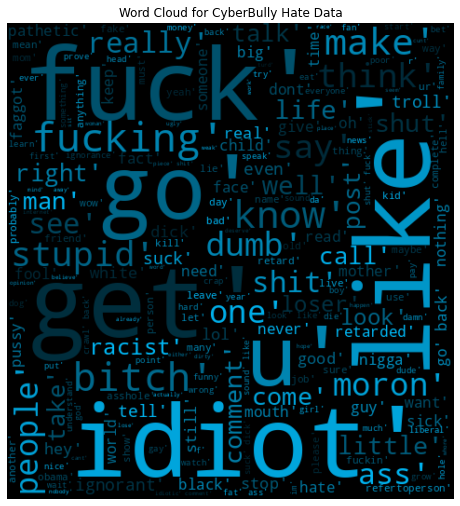

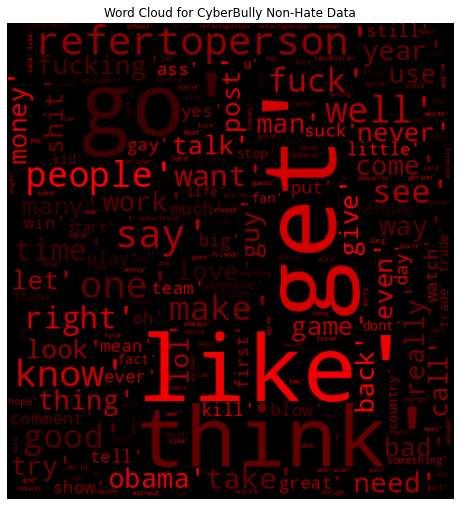

In [0]:
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud, get_single_color_func, STOPWORDS
 
def generate_wc(text:str, color_func:object, hate:bool=True) -> None:
    """Generates a wordcloud of most common words seen
    Args:
        - text: string of all words
        - color_func: function used to select color type
    Returns:
        Displays wordcloud plot
    """
    wordCloud=WordCloud(mask=None, 
                        width=480,
                        height=512,
                        random_state=20,
                        max_font_size=110,
                        stopwords=set(" ".join(string.punctuation).split(" ")+ list(STOPWORDS)),
                        background_color=None)\
    .generate(text)
    # Set Theme color
    wordCloud.recolor(color_func=color_func)
    # Change size
    plt.figure(figsize=(8,12))
    plt.imshow(wordCloud,interpolation='bilinear')
    # Set title
    title_type = 'Hate' if hate else 'Non-Hate'
    plt.title(f'Word Cloud for CyberBully {title_type} Data')
    # Show plot
    plt.axis('off')
    plt.show()
    
# Colors
color_func1 = get_single_color_func('deepskyblue')
color_func2 = get_single_color_func('red')
# String of words
hate_words=" ".join(["".join(map(str, item)) for item in (df.select('TokensNoPunct').filter("insult==1").rdd.collect())])
non_hate_words=" ".join(["".join(map(str, item)) for item in (df.select('TokensNoPunct').filter("insult==0").rdd.collect())])

# Show Hate Plot
generate_wc(hate_words, color_func1)
# Show Non-Hate Plot
generate_wc(non_hate_words, color_func2, False)

# Modeling Preparation

To prepare for modeling we first split our data into train and test sets. We also created a function to allow us to score across all our models and compare their effectiveness using the following measures: F1, Recall & Precission.

In [0]:
train_data, test_data = transformed_df.randomSplit([0.7,0.3], seed=42)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# # List to add all evaluations
evaluations = list()

def scoreModel(scores_dict:dict, eval_list:list) -> list:
    """ Given a dictionary of model scores {name:scores} prints evaluations and returns list of evaluations
    Args:
        - scores_dict(dict): dictionary of score models
        - eval_list(list): list of evaluations to add to
    Returns:
        list of dictionary scores
    """
    for model, score in scores_dict.items():
        evaluator = MulticlassClassificationEvaluator(labelCol='Insult')
        # F1
        f1 = evaluator.evaluate(score, {evaluator.metricName: "f1"})
        # Recall
        recall = evaluator.evaluate(score, {evaluator.metricName: "recallByLabel",
                                            evaluator.metricLabel: 1.0})
        # Precision
        precision = evaluator.evaluate(score, {evaluator.metricName: "precisionByLabel",
                                               evaluator.metricLabel: 1.0})
        # AUC
        binaryEvaluator = BinaryClassificationEvaluator(labelCol='Insult')
        if 'bert' not in model.lower():
            auc = binaryEvaluator.evaluate(score)
            print(f'{model} - AUC: {auc:.4f}')
        else:
            print(model)
        print(f'\tF1: {f1:.2f}\n\tRecall: {recall:.2f}\n\tPrecision: {precision:.2f}')
        
        # Confusion Matrix
        # predictionAndLabels = scores.select('prediction', f.col('Insult').cast('float').alias('label')).rdd.map(tuple)
        # metrics = MulticlassMetrics(predictionAndLabels)
        # confusion_matrix = metrics.confusionMatrix().toArray()
        # print(f'\t{confusion_matrix}')
        
        # Dictionary to return
        evaluation = {'model-approach':model, 'f1':f1, 'recall':recall, 'precision':precision}
        eval_list.append(evaluation)
    return eval_list

# Modeling

For each model we tried 4 approaches for comparions:

1. Count Vectorization (CV)
  - With Punctuations
  - Without Punctuations
2. Term-Frequency Inverse Document-Frequency (TFIDF)
  - With Punctuations
  - Without Punctuations

## Logistic Regression
This model served as our baseline giving pretty good outcomes with a top F1 score of 72

Observations:
- Text with no punctuations performs better
- Count Vectorizations also appear to perform better in comparison

In [0]:
from pyspark.ml.classification import LogisticRegression
 
# Punct CV
lr_punct_cv = LogisticRegression(
                         featuresCol='cvPunct',
                         labelCol='Insult')
 
# Punct TFIDF
lr_punct_tfidf = LogisticRegression( 
                         featuresCol='tfidfFeaturesPunct',
                         labelCol='Insult')
 
# NoPunct CV
lr_nopunct_cv = LogisticRegression( 
                         featuresCol='cvFeatures',
                         labelCol='Insult')
 
# NoPunct TFIDF
lr_nopunct_tfidf = LogisticRegression( 
                         featuresCol='tfidfFeatures',
                         labelCol='Insult')
 
 
# Fit Models
lr_model_tfidf_punct = lr_punct_tfidf.fit(train_data)
lr_model_cv_punct = lr_punct_cv.fit(train_data)
lr_model_tfidf_nopunct = lr_nopunct_tfidf.fit(train_data)
lr_model_cv_nopunct = lr_nopunct_cv.fit(train_data)

 
# Evaluate on Test
scores_lr_tfidf_punct = lr_model_tfidf_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_lr_tfidf_nopunct = lr_model_tfidf_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_lr_cv_punct = lr_model_cv_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_lr_cv_nopunct = lr_model_cv_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')

# Scores
lr_scores = {
    'LR-CV Punct': scores_lr_cv_punct,
    'LR-CV No Punct': scores_lr_cv_nopunct,
    'LR-TFIDF Punct': scores_lr_tfidf_punct,
    'LR-TFIDF No Punct': scores_lr_tfidf_nopunct
}

# Evaluation
evaluations = scoreModel(lr_scores, evaluations)

LR-CV Punct - AUC: 0.6833
	F1: 0.71
	Recall: 0.47
	Precision: 0.46
LR-CV No Punct - AUC: 0.6938
	F1: 0.72
	Recall: 0.49
	Precision: 0.46
LR-TFIDF Punct - AUC: 0.6840
	F1: 0.71
	Recall: 0.50
	Precision: 0.44
LR-TFIDF No Punct - AUC: 0.6907
	F1: 0.71
	Recall: 0.52
	Precision: 0.44


## Support Vector Classifier (SVC)
The SVC models appear to perform much better than the Logistic Regression (LR). This may indicate a non-liner relationship in our data.

Observations:
- No Punctuation Count Vectorization Approach has a better outcome with an AUC of 77.5%. 
- While the recall is similar to the LR model, the precision is nearly 20+ points better.

In [0]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Set up Models

### TFIDF - No punct
svm_tfidf_nopunct = LinearSVC(featuresCol="tfidfFeatures",
                labelCol="Insult",
                regParam=0.01)
### TFIDF - Punct
svm_tfidf_punct = LinearSVC(featuresCol="tfidfFeaturesPunct",
                labelCol="Insult",
                regParam=0.01)
### CV - No Punct
svm_cv_nopunct = LinearSVC(featuresCol="cvFeatures",
                labelCol="Insult",
                regParam=0.01)
### CV - Punct
svm_cv_punct = LinearSVC(featuresCol="cvPunct",
                labelCol="Insult",
                regParam=0.01)

### Ngrams
svm_ngrams_nopunct = LinearSVC(featuresCol="ngram4IdfFeatures",
                labelCol="Insult",
                regParam=0.01)

# Fit Models
model_tfidf_nopunct = svm_tfidf_nopunct.fit(train_data)
model_tfidf_punct = svm_tfidf_punct.fit(train_data)
model_cv_nopunct = svm_cv_nopunct.fit(train_data)
model_cv_punct = svm_cv_punct.fit(train_data)
model_ngrams_nopunct = svm_ngrams_nopunct.fit(train_data)

# Evaluate on Test
scores_tfidf_nopunct = model_tfidf_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_tfidf_punct = model_tfidf_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_cv_nopunct = model_cv_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_cv_punct = model_cv_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_ngrams_nopunct = model_ngrams_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
# scores_cv.display()

# Create a dictionary of model socres & approach names
svm_scores = {
    'SVM-CV No Punct': scores_cv_nopunct,
    'SVM-CV Punct': scores_cv_punct,
    'SVM-TFIDF No Punct': scores_tfidf_nopunct,
    'SVM-TFIDF Punct': scores_tfidf_punct,    
    'SVM-Ngrams': scores_ngrams_nopunct
}

# Evaluations
evaluations = scoreModel(svm_scores, evaluations)


SVM-CV No Punct - AUC: 0.7750
	F1: 0.78
	Recall: 0.46
	Precision: 0.67
SVM-CV Punct - AUC: 0.7715
	F1: 0.78
	Recall: 0.45
	Precision: 0.67
SVM-TFIDF No Punct - AUC: 0.7714
	F1: 0.78
	Recall: 0.49
	Precision: 0.61
SVM-TFIDF Punct - AUC: 0.7584
	F1: 0.77
	Recall: 0.46
	Precision: 0.61
SVM-Ngrams - AUC: 0.4949
	F1: 0.62
	Recall: 0.07
	Precision: 0.20


## Naive Bayes (NB)

In prior experiences we know that Naive Bayes models tend to perform better with text data, however in this validation we can see that our model performs worst than our base (LR) model with an AUC around 56%.

Observation:
- The approaches with no punctuations also seem to perform better.
- TFIDF performs slightly better than CV

In [0]:
from pyspark.ml.classification import NaiveBayes

# Punct CV
nb_punct_cv = NaiveBayes(modelType="multinomial", 
                         featuresCol='cvPunct',
                         labelCol='Insult')

# Punct TFIDF
nb_punct_tfidf = NaiveBayes(modelType="multinomial", 
                         featuresCol='tfidfFeaturesPunct',
                         labelCol='Insult')

# NoPunct CV
nb_nopunct_cv = NaiveBayes(modelType="multinomial", 
                         featuresCol='cvFeatures',
                         labelCol='Insult')

# NoPunct TFIDF
nb_nopunct_tfidf = NaiveBayes(modelType="multinomial", 
                         featuresCol='tfidfFeatures',
                         labelCol='Insult')


# Fit Models
nb_model_tfidf_punct = nb_punct_tfidf.fit(train_data)
nb_model_cv_punct = nb_punct_cv.fit(train_data)
nb_model_tfidf_nopunct = nb_nopunct_tfidf.fit(train_data)
nb_model_cv_nopunct = nb_nopunct_cv.fit(train_data)

# Evaluate on Test
scores_nb_tfidf_punct = nb_model_tfidf_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_nb_tfidf_nopunct = nb_model_tfidf_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_nb_cv_punct = nb_model_cv_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_nb_cv_nopunct = nb_model_cv_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')

# Scores
nb_scores = {
    'NB-CV Punct': scores_nb_cv_punct,
    'NB-CV No Punct': scores_nb_cv_nopunct,
    'NB-TFIDF Punct': scores_nb_tfidf_punct,
    'NB-TFIDF No Punct': scores_nb_tfidf_nopunct
}

# Evaluations
evaluations = scoreModel(nb_scores, evaluations)


NB-CV Punct - AUC: 0.5554
	F1: 0.76
	Recall: 0.44
	Precision: 0.58
NB-CV No Punct - AUC: 0.5574
	F1: 0.76
	Recall: 0.47
	Precision: 0.58
NB-TFIDF Punct - AUC: 0.5636
	F1: 0.70
	Recall: 0.62
	Precision: 0.43
NB-TFIDF No Punct - AUC: 0.5650
	F1: 0.70
	Recall: 0.63
	Precision: 0.44


## Random Forest Classifier (RCF)

It is apparent that the Random Forest Classifier with 20 trees appears to perform worst than our base (LR) model. It also appears that most of the predictions are for non-hate (non-insult) labels.

Observations:
- There were only 2 predictions that our model made for 'Hate' (Insults), and these two were ascertained. This is the reason why we have 100% precision for two of these models. 
- All predicion (except 2) were classified as non-hate
- The TFIDF no punctuation approach appears to perform better than the others

In [0]:
from pyspark.ml.classification import RandomForestClassifier

# Set up Models

### TFIDF - No punct
rf_tfidf_nopunct = RandomForestClassifier(featuresCol="tfidfFeatures",
                labelCol="Insult")
### TFIDF - Punct
rf_tfidf_punct = RandomForestClassifier(featuresCol="tfidfFeaturesPunct",
                labelCol="Insult")
### CV - No Punct
rf_cv_nopunct = RandomForestClassifier(featuresCol="cvFeatures",
                labelCol="Insult")
### CV - Punct
rf_cv_punct = RandomForestClassifier(featuresCol="cvPunct",
                labelCol="Insult")


# Fit Models
model_rf_tfidf_nopunct = rf_tfidf_nopunct.fit(train_data)
model_rf_tfidf_punct = rf_tfidf_punct.fit(train_data)
model_rf_cv_nopunct = rf_cv_nopunct.fit(train_data)
model_rf_cv_punct = rf_cv_punct.fit(train_data)

# Evaluate on Test
scores_rf_tfidf_nopunct = model_rf_tfidf_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_rf_tfidf_punct = model_rf_tfidf_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_rf_cv_nopunct = model_rf_cv_nopunct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')
scores_rf_cv_punct = model_rf_cv_punct.transform(test_data).select('Insult', 'prediction', 'rawPrediction')

# Scores
rf_scores = {
    'RF-CV Punct': scores_rf_cv_punct,
    'RF-CV No Punct': scores_rf_cv_nopunct,
    'RF-TFIDF Punct': scores_rf_tfidf_punct,
    'RF-TFIDF No Punct': scores_rf_tfidf_nopunct
}

# Evaluation
evaluations = scoreModel(rf_scores, evaluations)


RF-CV Punct - AUC: 0.6602
	F1: 0.63
	Recall: 0.00
	Precision: 1.00
RF-CV No Punct - AUC: 0.6574
	F1: 0.63
	Recall: 0.00
	Precision: 1.00
RF-TFIDF Punct - AUC: 0.6739
	F1: 0.62
	Recall: 0.00
	Precision: 0.00
RF-TFIDF No Punct - AUC: 0.6819
	F1: 0.62
	Recall: 0.00
	Precision: 0.00


## BERT Pre-Trained Model
We also attempted a more sophisticated model by uing NLP-Spark's BERT Pre-trained model. This model was trained in detecting hate from insults written in text comments. 

Since this a sequential model that takes in to consideration the context (previous and subsequent words), to be able to apply this model we need pass two inputs:
1. Full Sentence (Doc)
2. Tokenized Sentence

Despite using this more sophisticated model we see that this model does not perform better than some of our more simplistic models (SVC). We could try to re-train some of the higher layers of this model to achiever higher performance.

In [0]:
from sparknlp.annotator import BertForSequenceClassification
from pyspark.sql.types import DoubleType

# TokenAssembler - converts tokens back into doc(sentences), uses preprocessed pipeline outputs
tokenAssembler = TokenAssembler() \
   .setInputCols(["NormalizedDocument", "Normalized"]) \
   .setOutputCol("CleanDoc")

# test split for bert predictions
_, bert_test = tokenAssembler.transform(preprocessed).select('CleanDoc', 'Normalized', 'Insult').randomSplit([0.7,0.3], seed=42)
# Takes two inputs: Tokens and A CleanDoc(Sentence)

# Pretrained Bert Class Model
sequenceClassifier = BertForSequenceClassification \
      .pretrained('bert_sequence_classifier_dehatebert_mono', 'en') \
      .setInputCols(['Normalized', 'CleanDoc']) \
      .setOutputCol('Class') \
      .setMaxSentenceLength(512)

# Fit Transform
results = sequenceClassifier.transform(bert_test)

# Converting Output to Binary
@udf(returnType=DoubleType())
def to_binary(result:object, positive:str='HATE') -> float:
    """Converts string model prediction to binary if positive
    Args:
        - result(object): list output
        - positive(str): expected output that will return 1.0. Default to 'HATE'
    Returns:
        float binary (1.0, 0.0)
    """
    if len(result) > 0 and result[0] == positive:
        return 1.0
    else:
        return 0.0

# Score models   
scores = results.select('Insult', 'Class.result')\
    .withColumn('prediction', to_binary('result'))\
    .select('Insult', 'prediction', 'result')

bert_scores = {'BERT-Embeddings':scores}
evaluations = scoreModel(bert_scores, evaluations)

bert_sequence_classifier_dehatebert_mono download started this may take some time.
Approximate size to download 599 MB
[OK!]
BERT-Embeddings
	F1: 0.72
	Recall: 0.24
	Precision: 0.64


# Evaluation
Using F1 as our main measure, when comparing across all our different models and approaches we can see that the SVM model performed best. It is also apparent that No-Punctuation approaches outperform those with punctuations. We can also see that the Count Vectorization (CV) approach appear performs better than the rest.

The Ngram approach also appears to perform worst in comparison to all the other approaches.

In [0]:
# Show Final Models ranked by F1
column_order = ['model-approach', 'f1', 'recall', 'precision']
final_evaluations = spark.createDataFrame(evaluations).select(column_order).sort('f1', ascending=False)
display(final_evaluations)

model-approach,f1,recall,precision
SVM-CV No Punct,0.7840183021310723,0.463855421686747,0.6657060518731989
SVM-CV Punct,0.7801884537342275,0.4457831325301205,0.6666666666666666
SVM-TFIDF No Punct,0.7757470527593735,0.4939759036144578,0.6119402985074627
SVM-TFIDF Punct,0.7691020961023145,0.463855421686747,0.6078947368421053
NB-CV No Punct,0.7614564237685492,0.4678714859437751,0.5796019900497512
NB-CV Punct,0.7579978007607967,0.4397590361445783,0.584
BERT-Embeddings,0.7223740867756949,0.24096385542168675,0.6417112299465241
LR-CV No Punct,0.7161870630044197,0.4919678714859438,0.4596622889305816
LR-CV Punct,0.7137917341011394,0.4738955823293173,0.4564796905222437
LR-TFIDF No Punct,0.7083357216108526,0.5240963855421686,0.44387755102040816


# Conclusion
To be able to identify potential hate in tweets/comments we recommend to use the SVC model with no punctuations and a CV as inputs. We could use this approach to give a pop-up message to ask our users to reconsider if potential hate is captured by the user.

To be able to increase model's performace here are some approaches that can be tested:
  - Data Balancing = trying Synthetic data balancing approaches that can help our model better identify hateful messges
  - Friends Context = trying to implement a flag to determine if the recipient of the message is a listed friend for the user, this could help us improve our precision by noting insult usage that are not intended to harm or demonstrate hate but rather high positive emotions.
  - NGrams (different word configuration 2,3) = Try different Ngram configurations to see if this approaches perform better
  - Cut-Off Thresholds for Precision/Recall = Implement a cut-off for the threshold to increase recall/precission depending on what we care about most.